In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import tqdm
import os

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.ode.acodes     import ODE
from src.rates          import initialise_abs, calculate_rates
from src.input          import setinput, getcst

from scipy.integrate    import solve_ivp
from astropy            import constants

### Physical constants

In [40]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()

## input values physics
ρ, T, δ, Av, chemtype = setinput()

## input chemistry
chemtype = 'C'

## calculate H accretion on dust
Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

yr_to_sec = units.year.to('s')         ## year in seconds

In [38]:
'''
TODO 
om te vermijden dat er kei veel moet geloopt worden over elke lijst van elke input parameter, 
kan er gesplit worden gewoon op spatie, en dan een ander keyword meegeven om te beslissen of alle
params gecombineerd worden, of dat het per model is.

'''



infile = '/lhome/silkem/ChemTorch/ChemTorch/input/input.txt'

filelines = list()

with open(infile, 'r') as f:
    lines = f.readlines()
    

print(lines)


for i in range(len(lines)):
    lines[i]=lines[i].replace(' \n', '')
    lines[i]=lines[i].replace('\n', '')
    lines[i]=lines[i].split(' ')

    if lines[i][0] == 'dens':
        dens_idx = i
        dens_line = lines[i][2:]

    if lines[i][0] == 'temp':
        temp_idx = i
        temp_line = lines[i][2:]

    if lines[i][0] == 'delta':
        delta_idx = i
        delta_line = lines[i][2:]

    if lines[i][0] == 'Av':
        Av_idx = i
        Av_line = lines[i][2:]


print(dens_line)
print(temp_line)

if len(dens_line) > 1 and dens_line[1] == ':':
    type = 'single'

if len(dens_line) > 1 and dens_line[1] == ';':
    type = 'combine'

else: type = 'none'

print(type)

input = dict()

['### Inputfile TorchChem ###\n', '### ------------------- ###\n', '\n', '## Use : to split input to create specific models.\n', '## Use ; to cross all input values.\n', '\n', '\n', '## --\n', '\n', '# density [Msol/yr]\n', 'dens = 1e-6 ; 1e-5\n', '\n', '# temperature [K]\n', 'temp = 2000\n', '\n', '# overall dilution of the radiation field\n', 'delta = 1\n', '\n', '# species-specific extinction (connected to optical depth)\n', 'Av = 1\n', '\n', '## --']
['1e-6', ';', '1e-5']
['2000']
combine


### Three body reactions

In [2]:
def read_rate_file():

    loc = 'rates/rate16_IP_2330K_AP_6000K.rates'

    rates = dict()
    with open(loc, 'r') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            line = lines[i].split(':')
            rates[int(line[0])] = line[1:]
    
    type = list()
    no = list()
    α = np.zeros(len(rates))
    β = np.zeros(len(rates))
    γ = np.zeros(len(rates))
    for nb in rates:
        no.append(nb)
        type.append(str(rates[nb][0]))
        α[nb-1] = float(rates[nb][8])
        β[nb-1] = float(rates[nb][9])
        γ[nb-1] = float(rates[nb][10])

    return rates, no, type, α, β, γ

In [1]:
# Read the rates file and return the rate coefficients per reaction: 
#               reaction no.:type:R1:R2:P1:P2:P3:P4:NE:α : β : γ: Tl :Tu:ST:ACC:REF
# indices                 0    1  2  3  4  5  6  7  8  9  10  11  12  13 14 15 

In [63]:
rates, no, type, α, β, γ = read_rate_file()

In [4]:
def read_specs_file(chemtype):

    loc = 'rates/rate16_IP_6000K_'+chemtype+'rich_mean_Htot.specs'

    # specs = dict()

    specs = np.loadtxt(loc, skiprows=1,   max_rows=466, usecols=(1), dtype=str)
    consv = np.loadtxt(loc, skiprows=468, max_rows=2  , usecols=(1), dtype=str)
    parnt = np.loadtxt(loc, skiprows=471   , usecols= (0,1), dtype=str)
    

    return specs, (parnt).T, consv

specs, parnt, consv = read_specs_file('C')

### CO self-shielding (Visser et al. 2009)

In [83]:
from pathlib import Path


def COshield_rewrite(loc):
    print(loc)

    ## Read file
    with open(loc, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):                 ## remove '\n'
        lines[i]=lines[i].replace('\n', '')


    ## Retrieve values for N(H2) and N(CO)
    idx_H2 = lines.index('N(H2)')
    idx_CO = lines.index('N(12CO)')
    idx_sh = lines.index('12C16O')
    CO = list()
    for i in range(idx_CO+1, idx_H2):
        CO.append(lines[i])
    H2 = list()
    for i in range(idx_H2+1, idx_sh):
        H2.append(lines[i])

    ## get shielding rates in convenient format
    shield = list()
    row = ''
    for i in range(idx_sh+1, len(lines)-1):
        # print(i,len(lines))
        if i == len(lines)-2:
            # print('last')
            row = row + lines[i] + lines[i+1]
            shield.append(row)
            row = ''
        elif len(lines[i]) >= len(lines[i+1]):
            row = row + lines[i]
        else:
            row = row + lines[i]
            shield.append(row)
            row = ''

    ## write out again in convenient form
    with open(loc, 'w') as f:
        for i in range(idx_CO):
            f.write(lines[i]+'\n')
        f.write('\n')
        f.write('CO shielding rates     (for parameters/values rows & columns: check legend file)\n')
        for row in shield:
            f.write(row+'\n')

    legend = './shielding/CO/legend.txt'
    with open(legend, 'w') as f:
        f.write('Legend of CO shielding tables\n')
        f.write('\n')
        f.write('N(CO) - rows       N(H2) - columns\n')
        for i in range(len(H2)):
            f.write(CO[i]+'     '+H2[i]+'\n')
        for i in range(len(H2), len(CO)):
            f.write(CO[i]+'\n')

    return



def N2shield_rewrite(loc):
    print(loc)

    ## Read file
    with open(loc, 'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):                 ## remove '\n'
        lines[i]=lines[i].replace('\n', '')


    ## Retrieve values for N(H2) and N(N2)
    idx_H2 = lines.index('N(H2)')
    idx_N2 = lines.index('N(14N2)')
    idx_sh = lines.index('14N2')
    idx_stop = lines.index('14N15N')
    N2 = list()
    for i in range(idx_N2+1, idx_H2):
        N2.append(lines[i])
    H2 = list()
    for i in range(idx_H2+1, idx_sh):
        H2.append(lines[i])

    ## get shielding rates in convenient format
    shield = list()
    for i in range(idx_sh+1, idx_stop):
        shield.append(lines[i])
        
    ## write out again in convenient form
    with open(loc, 'w') as f:
        for i in range(idx_N2):
            f.write(lines[i]+'\n')
        f.write('\n')
        f.write('N2 shielding rates     (for parameters/values rows & columns: check N2 legend file)\n')
        for row in shield:
            f.write(row+'\n')

    legend = './shielding/N2/legend.txt'
    with open(legend, 'w') as f:
        f.write('Legend of N2 shielding tables\n')
        f.write('\n')
        f.write('N(N2) - rows       N(H2) - columns\n')
        for i in range(len(H2)):
            f.write(N2[i]+'     '+H2[i]+'\n')
        for i in range(len(H2), len(N2)):
            f.write(N2[i]+'\n')

    return
 


In [46]:
def read_shielding(loc, spec):
    '''
    Read in shielding rates from tables.
    '''
    shielding = np.loadtxt(loc, skiprows=9, dtype=np.float64)
    leg = './shielding/'+spec+'/legend.txt'

    spec = np.loadtxt(leg, skiprows = 3, dtype = np.float64, usecols = (0))
    H2 = np.loadtxt(leg, skiprows = 3, dtype = np.float64, usecols = (1), max_rows=shielding.shape[0])

    return shielding, spec, H2

## retrieve shielding rate, given N_CO & N_H2

def find_closest_lin(list, x, spec):
    '''
    Find index of list for the value closest to x. \n
    This function is specific for a loglinear 'list', \n with the first element (index 0) diverging from this relation.
    '''

    ## Consider log space.
    list = np.log10(list)
    x    = np.log10(x)

    if spec == 'CO':
        ## Exeption if x is smaller than the first value.
        if x < list[1]:
            if x < list[1]/2:
                return 0
            else:
                return 1
        ## Exeption when x is larger than the last value.
        elif x >= list[-1]:
            return int(len(list)-1)
        ## All values in between.
        else:
            list = list[1:]
            min = np.min((list))
            max = np.max((list))

            idx = np.round((x-min)*(max-min)**(-1)*(len(list)-1))

            return int(idx+1)
    
    elif spec == 'N2':
        ## Exeption when x is larger than the last value.
        if x >= list[-1]:
            return int(len(list)-1)
        ## All values in between.
        else:
            min = np.min((list))
            max = np.max((list))

            idx = np.round((x-min)*(max-min)**(-1)*(len(list)-1))

            return int(idx)
        

def retrieve_rate(n_i, Av, T, spec):
    '''
    Retrieve the shielding rate, corresponding best to the current modelling input parameters. \n
    Input: \n
        - N         = target column density of the specific species (CO or N2)\n
        - N_H2      = target column density of H2 \n
        - shielding = shielding table in 2D-np.array \n
        - spec      = list with column densities from species \n
        - H2        = list with column densities from H2
    '''

    shielding, lgd_spec, lgd_H2 = read_shielding(dir_shielding+'CO/'+loc, 'CO')

    N_H2 = Av * 1.87e21
    N = N_H2 * n_i[spec] 
    
    idx = find_closest_lin(lgd_spec, N, spec)
    idx_H2 = find_closest_lin(lgd_H2, N_H2, spec)
   
    shieldrate = shielding[idx_H2, idx]

    return shieldrate


def get_shield_table(T, spec):
    '''
    Function to select the most appropriate sheilding table.
    '''
    T_list_CO = np.array([5,20,50,100])
    T_list_N2 = np.array([10,30,50,100,1000])

    if spec == 'CO':
        list = T_list_CO
    elif spec == 'N2':
        list= T_list_N2

    idx = find_closest(list, T)
    temp = list[idx]

    return temp

def find_closest(list, target):
    idx = 0
    for i in range(len(list)-1):
        if np.abs(list[i+1]-target) <= np.abs(list[i]-target):
            idx = i+1
    return idx


In [57]:
target = 78
list = np.array([1,4,29,40,100,500])

idx = find_closest(list, target)

print(idx,list[idx]) 

4 100


In [5]:
dir_shielding = './shielding/'

In [34]:
loc = 'shield.03.5.35-557-36.dat'

COshielding, CO, H2 = read_shielding(dir_shielding+'CO/'+loc, 'CO')
COrate = retrieve_rate(1.e17,2.e20, COshielding, CO, H2, 'CO')
print(COrate)

46 41
3.875e-07


In [35]:
loc = 'Tex_10K_bH2_3km.s-1_bH_5km.s-1_NH_1e+14cm-2.dat'
N2shielding, N2, H2 = read_shielding(dir_shielding+'N2/'+loc, 'N2')
Av = 0.05  
n_i = 2.00E-05
N2rate = retrieve_rate(n_i, Av, N2shielding, N2, H2, 'N2')
print(N2rate)

26 30
0.05326


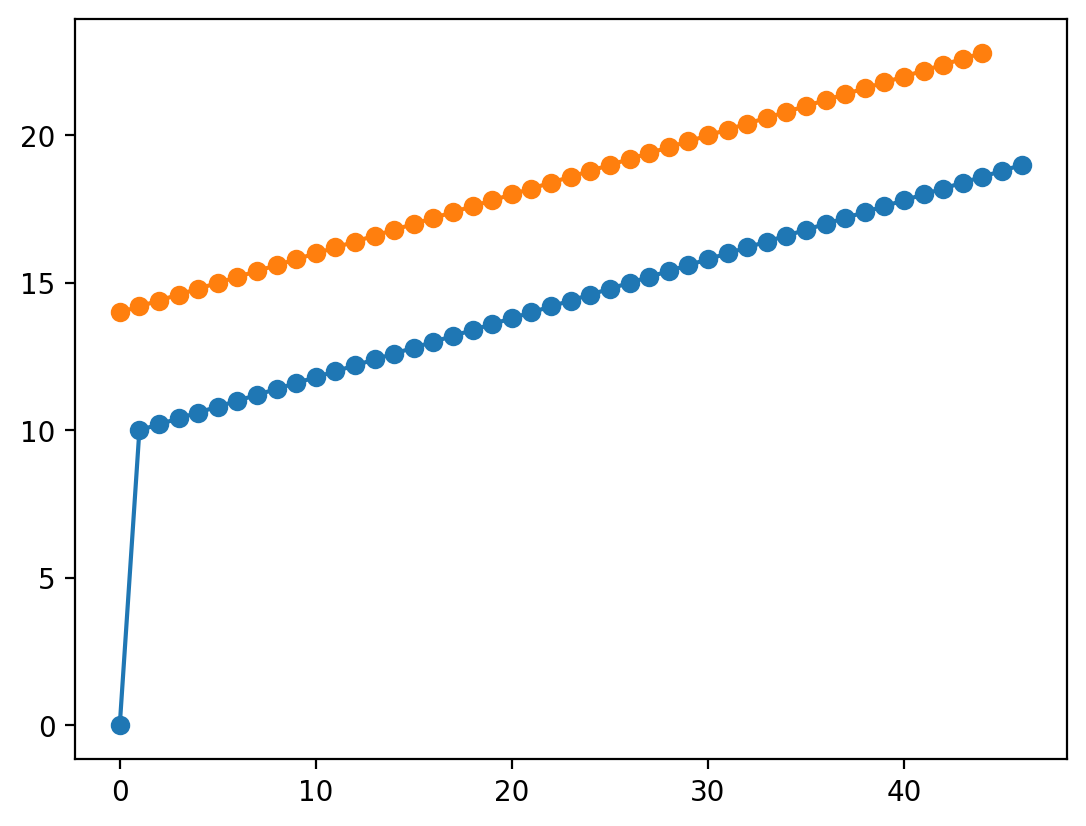

In [36]:
plt.plot(np.log10(CO), '-o')
plt.plot(np.log10(H2), '-o')


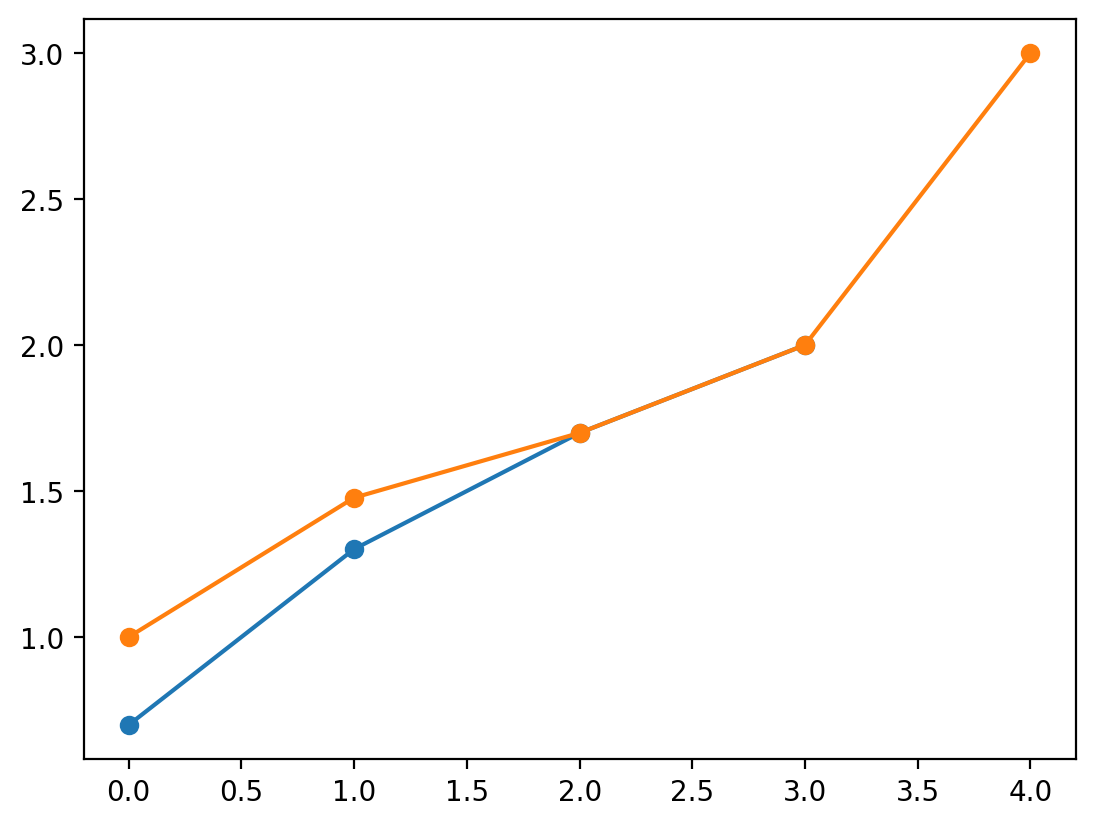

In [58]:
plt.plot(np.log10(np.array([5, 20, 50, 100])), '-o')
plt.plot(np.log10(np.array([10,30,50,100,1000])), '-o')

In [23]:
def read_rate_file(rate):
    '''
    Read rates file (Rate12, UMIST database, including IP, AP, HNR - reactions) \ 
    (McElroy et al., 2013, M. VdS' papers)
    '''

    loc = '/lhome/silkem/ChemTorch/ChemTorch/rates/rate'+str(rate)+'.rates'

    rates = dict()
    with open(loc, 'r') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            line = lines[i].split(':')
            rates[int(line[0])] = line[1:]
    
    type = list()
    α = np.zeros(len(rates))
    β = np.zeros(len(rates))
    γ = np.zeros(len(rates))
    for nb in rates:
        type.append(str(rates[nb][0]))
        α[nb-1] = float(rates[nb][8])
        β[nb-1] = float(rates[nb][9])
        γ[nb-1] = float(rates[nb][10])

    return rates, type, α, β, γ


## Calculating the reaction rates

def calculate_rates(T, δ, Av, rate):
    '''
    Calculate the reaction rate for all reactions.

    First read in reaction rate file, from this, depending on the reaction type, \ 
    the correct reaction rate is calculated.
    '''

    rates, type, α, β, γ = read_rate_file(rate)   

    k = np.zeros(len(type))

    for i in range(len(type)):
        reaction = type[i]
        if reaction == 'PH':
            if rates[i+1][1] == 'CO':
                print(i, rates[i+1][1])
            elif rates[i+1][1] == 'N2':
                print(i, rates[i+1][1])

        if type[i] == 'CP':
            k[i] = CP_rate(α[i]) 
        elif type[i] == 'CR':
            k[i] = CR_rate(α[i], β[i], γ[i], T)
        elif type[i] == 'PH':
            if rates[i+1][1] == 'CO':
                print(i, rates[i+1][1])
            elif rates[i+1][1] == 'N2':
                print(i, rates[i+1][1])
            k[i] = photodissociation_rate(α[i], γ[i], δ, Av)
        elif type[i] == 'IP':
            k[i] = 0
        elif type[i] == 'AP':
            k[i] = 0
        else:
            k[i] = Arrhenius_rate(α[i], β[i], γ[i], T)

    return k

    ## Setting initial abundances
def initialise_abs(chemtype, rate):
    '''
    This function sets the initial abundance of the species: 

    INPUT:
        chemtype = chemistry type: 'C' of 'O'

    RETURN:
        - abs       = abundances of non-conserved species 
        - abs_consv = abundances of conserved species 
        - specs     = array with species names 
        (The order of specs corresponds to the order of abs)
    '''
    specs, parnt, consv = read_specs_file(chemtype, rate)

    ## Initial abundances of the non-conserved species
    abs = np.zeros(len(specs),dtype=np.float64)

    for i in range(len(specs)):
        for j in range(parnt.shape[1]):
            if specs[i] == parnt[0][j]:
                abs[i] = parnt[1][j]

        if specs[i] == 'CO':
            nCO = abs[i]
        elif specs[i] == 'N2':
            nN2 = abs[i]

    ## Initialise abundances of the conserved species
    abs_consv = np.zeros(len(consv))
    abs_consv[1] = 0.5                  ## H2

    return abs, abs_consv, specs, nCO, nN2

In [24]:
k = calculate_rates(1, 1, 1, 13)

5893 CO
5963 N2


### Outflow density

In [51]:
def density(Mdot,v, r):
    '''
    Input 
        - mass-loss rate (Mdot) in units of Msol/yr
        - outflow velocity (v) in units of km/s
        - radius (r): location of the outflow, inputs of cm
    Output
        - density in units of g/cm^3
    '''
    # r    = 1e18 #* unt.cgs.cm                       # cm
    Mdot = Mdot * Msunyr                            # gram/s
    v    = v    * cms                               # cm/s


    dens = Mdot / (4*pi * v * r**2 * mu * mH)       # g/cm^3

    # dens = dens * g_to_kg * cm_to_m**(-3)           # kg/m^3

    return dens

In [52]:
r = 1.e15
print('{:.2E}'.format(density(1.e-5, 10., r)))
print('{:.2E}'.format(density(1.e-6, 15., r)))
print('{:.2E}'.format(density(1.e-7, 10., r)))
print('{:.2E}'.format(density(1.e-8, 5. , r)))

1.13E+07
7.51E+05
1.13E+05
2.25E+04
